# 🎮 CartPole 실습 - 3가지 에이전트 비교

## 📚 학습 목표
1. Gymnasium 환경 사용법 익히기
2. 세 가지 다른 에이전트 구현하기
3. 강화학습의 필요성 이해하기

---

## 1️⃣ 환경 설정 및 라이브러리 설치

In [2]:
# Gymnasium 설치
!pip install gymnasium

# 렌더링을 위한 패키지 설치 (Colab에서 영상 출력용)
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install pyvirtualdisplay
!pip install gymnasium[classic-control]

print("설치 완료! ✅")

설치 완료! ✅


In [3]:
# 필요한 라이브러리 임포트
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time


print("Gymnasium 버전:", gym.__version__)
print("라이브러리 임포트 완료! ✅")

Gymnasium 버전: 1.2.2
라이브러리 임포트 완료! ✅


In [4]:
from pyvirtualdisplay import Display
from IPython.display import Image as IPImage
import imageio

# 가상 디스플레이 시작
display_screen = Display(visible=0, size=(400, 300))
display_screen.start()

print("가상 디스플레이 시작 완료! ✅")

가상 디스플레이 시작 완료! ✅


---
## 2️⃣ CartPole 환경 소개

### 게임 설명:
- **목표**: 카트 위의 막대가 쓰러지지 않도록 균형 유지
- **행동**: 0(왼쪽) 또는 1(오른쪽)으로 카트 이동
- **보상**: 막대가 서 있으면 매 스텝마다 +1점
- **종료 조건**:
  - 막대가 15도 이상 기울어짐
  - 카트가 화면 밖으로 나감
  - 500스텝 달성 (최고 점수!)

### 관측값(Observation):
- `observation[0]`: 카트 위치
- `observation[1]`: 카트 속도
- `observation[2]`: 막대 각도
- `observation[3]`: 막대 각속도

In [43]:
# CartPole 환경 생성 및 정보 확인
env = gym.make('CartPole-v1')

print("CartPole 환경 정보")
print("="*50)
print(f"행동 공간: {env.action_space}")
print(f"  → 0: 왼쪽으로 이동")
print(f"  → 1: 오른쪽으로 이동")
print(f"\n상태 공간: {env.observation_space}")
print(f"  → 4개의 실수 값 (카트 위치, 속도, 막대 각도, 각속도)")

env.close()

CartPole 환경 정보
행동 공간: Discrete(2)
  → 0: 왼쪽으로 이동
  → 1: 오른쪽으로 이동

상태 공간: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
  → 4개의 실수 값 (카트 위치, 속도, 막대 각도, 각속도)


In [41]:
# 실행 결과 렌더링 함수
def render_and_save_gif(agent_type, filename, num_steps=200):
    """
    에이전트 실행을 GIF로 저장하고 표시
    """
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    frames = []

    observation, info = env.reset()
    total_reward = 0

    for step in range(num_steps):
        # 프레임 저장
        frame = env.render()
        frames.append(frame)

        # 행동 선택
        if agent_type == 'left':
            action = 0  # 항상 왼쪽
        elif agent_type == 'random':
            action = env.action_space.sample()  # 랜덤
        elif agent_type == 'rule':
            action = 1 if observation[2] > 0 else 0  # 규칙 기반

        observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward

        if terminated or truncated:
            break

    env.close()

    # GIF로 저장
    imageio.mimsave(filename, frames, fps=30)
    print(f"{filename} 저장 완료! (점수: {total_reward:.0f}점, {len(frames)}프레임)")

    return total_reward

---
## 3️⃣ 실습 1: 무조건 왼쪽으로만 가는 에이전트

가장 단순한 전략: 항상 왼쪽(0)으로만 이동합니다.

In [84]:
def left_only_agent(num_episodes=5):
    """
    무조건 왼쪽으로만 가는 에이전트
    """
    env = gym.make('CartPole-v1')
    episode_rewards = []

    print("🔴 무조건 왼쪽으로만 가는 에이전트")
    print("=" * 50)

    for episode in range(num_episodes):
        observation, info = env.reset()
        episode_reward = 0

        for step in range(500):  # 최대 500 스텝
            action = 0  # 항상 왼쪽으로 이동

            observation, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward

            if terminated or truncated:
                break

        episode_rewards.append(episode_reward)
        print(f"Episode {episode + 1}: {episode_reward:.0f}점")

    env.close()

    avg_reward = np.mean(episode_rewards)
    print(f"\n⭐ 평균 점수: {avg_reward:.2f}점")
    return episode_rewards, avg_reward


# 실행
left_rewards, left_avg = left_only_agent()

🔴 무조건 왼쪽으로만 가는 에이전트
Episode 1: 11점
Episode 2: 8점
Episode 3: 11점
Episode 4: 11점
Episode 5: 10점

⭐ 평균 점수: 10.20점


cartpole_left_agent.gif 저장 완료! (점수: 9점, 9프레임)


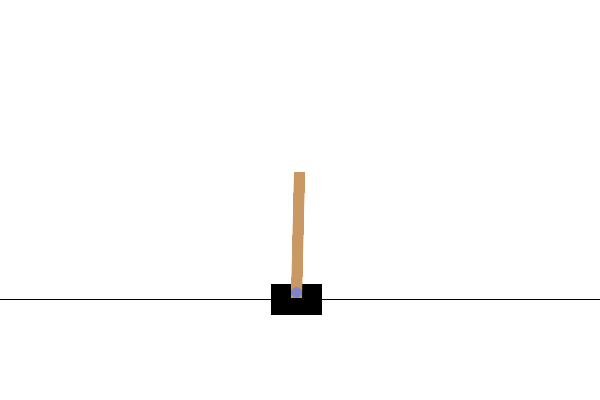

In [85]:
# 무조건 왼쪽 에이전트 실행 영상
render_and_save_gif('left', 'cartpole_left_agent.gif', num_steps=200)
IPImage('cartpole_left_agent.gif')

---
## 4️⃣ 실습 2: 랜덤 에이전트

매 스텝마다 무작위로 왼쪽(0) 또는 오른쪽(1)을 선택합니다.

In [225]:
def random_agent(num_episodes=5):
    """
    랜덤하게 행동하는 에이전트
    """
    # ✏️ TODO: 환경 생성
    env = gym.make('CartPole-v1')

    episode_rewards = []

    print("🟠 랜덤 에이전트")
    print("="*50)

    for episode in range(num_episodes):
        # ✏️ TODO: 환경 초기화
        observation, info = env.reset()


        episode_reward = 0

        for step in range(500):
            # ✏️ TODO: 랜덤 선택
            action = env.action_space.sample()


            # ✏️ TODO: 행동 실행 및 결과 반환
            observation, reward, terminated, truncated, info = env.step(action)


            episode_reward += reward

            if terminated or truncated:
                break

        episode_rewards.append(episode_reward)
        print(f"Episode {episode+1}: {episode_reward:.0f}점")

    env.close()

    avg_reward = np.mean(episode_rewards)
    print(f"\n⭐ 평균 점수: {avg_reward:.2f}점")
    return episode_rewards, avg_reward

# 실행
random_rewards, random_avg = random_agent()

🟠 랜덤 에이전트
Episode 1: 20점
Episode 2: 25점
Episode 3: 15점
Episode 4: 83점
Episode 5: 12점

⭐ 평균 점수: 31.00점


cartpole_random_agent.gif 저장 완료! (점수: 43점, 43프레임)


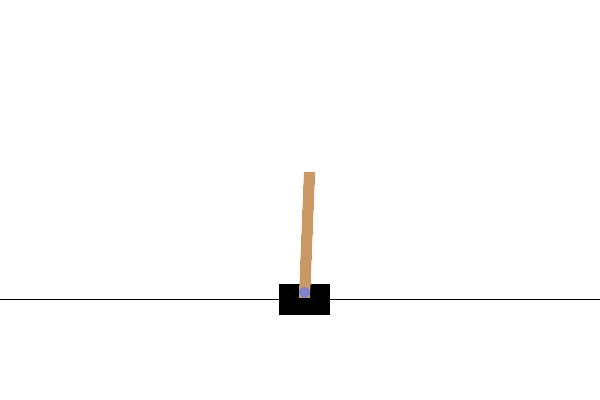

In [196]:
# 랜덤 에이전트 실행 영상
render_and_save_gif('random', 'cartpole_random_agent.gif', num_steps=200)
IPImage('cartpole_random_agent.gif')

---
## 5️⃣ 실습 3: 규칙 기반(if문) 에이전트

**간단한 규칙:**
- 막대가 오른쪽으로 기울면(각도 > 0) → 오른쪽으로 이동
- 막대가 왼쪽으로 기울면(각도 < 0) → 왼쪽으로 이동

이렇게 하면 막대가 기울어지는 방향으로 카트를 움직여서 균형을 유지할 수 있습니다!

In [289]:
def rule_based_agent(num_episodes=5):
    """
    규칙 기반 에이전트: 막대 각도를 보고 행동 결정
    """
    env = gym.make('CartPole-v1')
    episode_rewards = []

    print("🟢 규칙 기반(if문) 에이전트")
    print("="*50)

    for episode in range(num_episodes):
        observation, info = env.reset()
        episode_reward = 0

        for step in range(500):
            # observation[2]는 막대 각도
            pole_angle = observation[2]

            # 간단한 규칙: 막대가 기울어진 방향으로 이동
            # ✏️ TODO : 조건에 따른 막대 이동 if 문 작성
            if pole_angle > 0:
              action = 1
            else:
                action = 0


            observation, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward

            if terminated or truncated:
                break

        episode_rewards.append(episode_reward)
        print(f"Episode {episode+1}: {episode_reward:.0f}점")

    env.close()

    avg_reward = np.mean(episode_rewards)
    print(f"\n⭐ 평균 점수: {avg_reward:.2f}점")
    return episode_rewards, avg_reward

# 실행
rule_rewards, rule_avg = rule_based_agent()

🟢 규칙 기반(if문) 에이전트
Episode 1: 63점
Episode 2: 34점
Episode 3: 49점
Episode 4: 52점
Episode 5: 40점

⭐ 평균 점수: 47.60점


cartpole_rule_agent.gif 저장 완료! (점수: 57점, 57프레임)


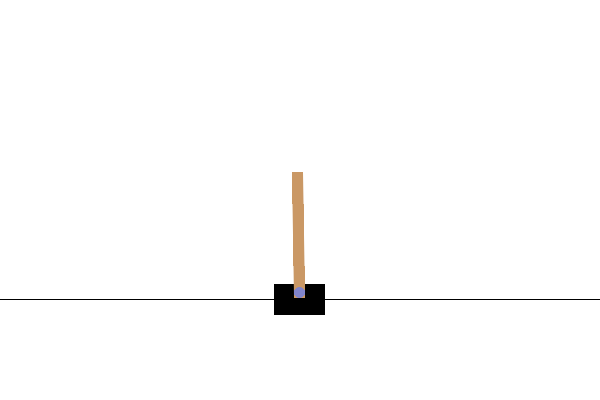

In [240]:
# 규칙 기반 에이전트 실행 영상
render_and_save_gif('rule', 'cartpole_rule_agent.gif', num_steps=500)
IPImage('cartpole_rule_agent.gif')

---
## 6️⃣ 결과 비교 및 시각화

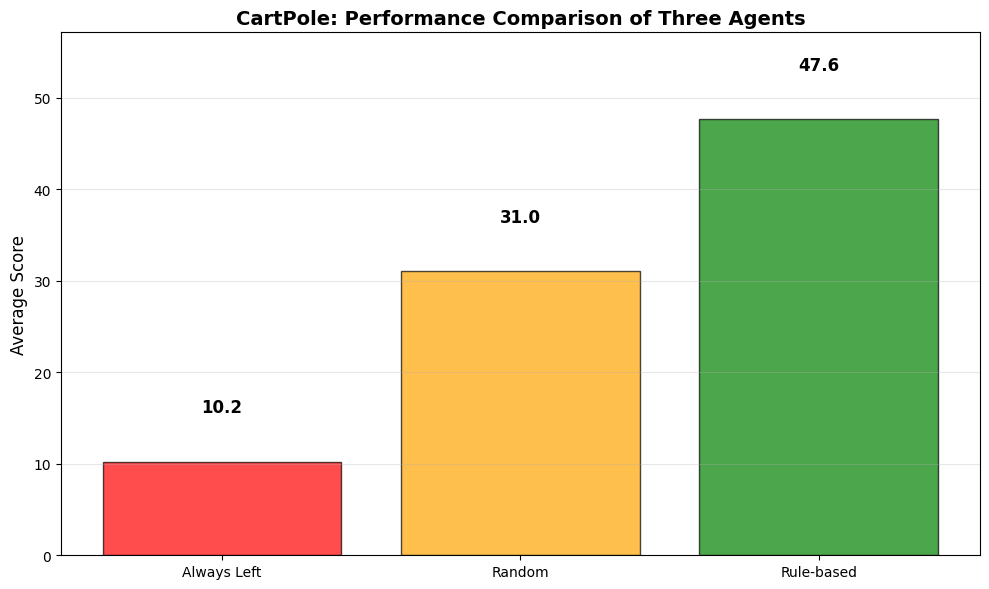


최종 결과
🔴 무조건 왼쪽: 10.20점
🟠 랜덤: 31.00점
🟢 규칙 기반: 47.60점


In [290]:
# 평균 점수 비교 그래프
agents = ['Always Left', 'Random', 'Rule-based']
avg_scores = [left_avg, random_avg, rule_avg]
colors = ['red', 'orange', 'green']

plt.figure(figsize=(10, 6))
bars = plt.bar(agents, avg_scores, color=colors, alpha=0.7, edgecolor='black')

# 막대 위에 점수 표시
for i, (bar, score) in enumerate(zip(bars, avg_scores)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'{score:.1f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Average Score', fontsize=12)
plt.title('CartPole: Performance Comparison of Three Agents',
          fontsize=14, fontweight='bold')
plt.ylim(0, max(avg_scores) * 1.2)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("최종 결과")
print("="*50)
print(f"🔴 무조건 왼쪽: {left_avg:.2f}점")
print(f"🟠 랜덤: {random_avg:.2f}점")
print(f"🟢 규칙 기반: {rule_avg:.2f}점")
print("="*50)

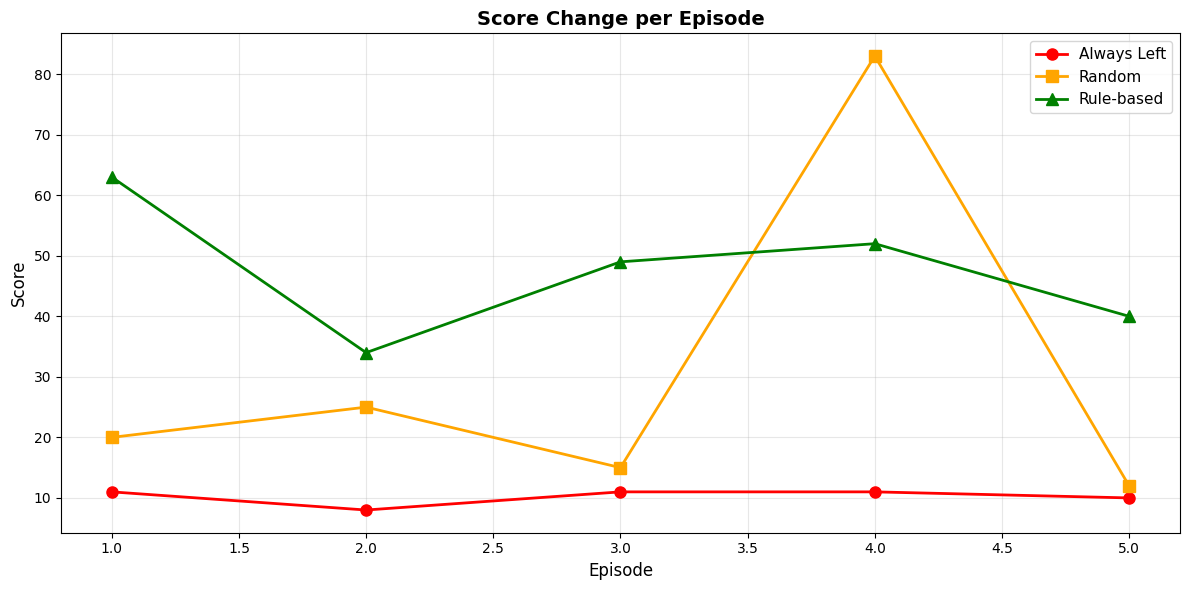

In [291]:
# 에피소드별 점수 변화 그래프
plt.figure(figsize=(12, 6))

episodes = range(1, 6)
plt.plot(episodes, left_rewards, 'o-', color='red', label='Always Left', linewidth=2, markersize=8)
plt.plot(episodes, random_rewards, 's-', color='orange', label='Random', linewidth=2, markersize=8)
plt.plot(episodes, rule_rewards, '^-', color='green', label='Rule-based', linewidth=2, markersize=8)

plt.xlabel('Episode', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Score Change per Episode', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 7️⃣ 규칙 기반 에이전트 실행 영상 보기

가장 성능이 좋은 규칙 기반 에이전트가 실제로 어떻게 플레이하는지 확인해봅시다!

실행 영상 저장 완료! (총 41프레임)


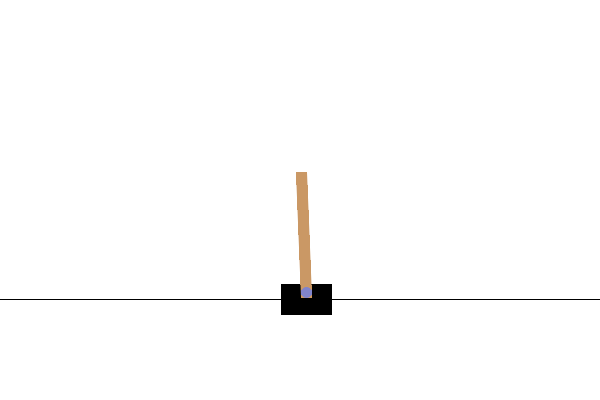

In [294]:
from pyvirtualdisplay import Display
from IPython.display import Image
import imageio

# 가상 디스플레이 시작
display_screen = Display(visible=0, size=(400, 300))
display_screen.start()

def render_agent(agent_type='rule'):
    """
    에이전트 실행을 GIF로 저장
    """
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    frames = []

    observation, info = env.reset()

    for step in range(500):
        # 프레임 저장
        frame = env.render()
        frames.append(frame)

        # 행동 선택
        if agent_type == 'rule':
            action = 1 if observation[2] > 0 else 0
        elif agent_type == 'random':
            action = env.action_space.sample()
        else:
            action = 0

        observation, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
            break

    env.close()

    # GIF로 저장
    imageio.mimsave('cartpole_rule_agent.gif', frames, fps=30)
    print(f"실행 영상 저장 완료! (총 {len(frames)}프레임)")

    return frames

# 규칙 기반 에이전트 실행 영상 생성
frames = render_agent('rule')

# GIF 출력
display.Image('cartpole_rule_agent.gif')